# Three-Phase Time Seriece Clustering

###### Original Algorithm
1. In the first phase of the model, data is pre-processed, transformed into a low dimensional space, and grouped approximately.
1. Then, the pre-clustered time series are refined in the second phase using an accurate clustering method, and are represented by some prototypes.
1. Finally, in the third phase, the prototypes are merged to construct the ultimate clusters.

#### Standard Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
np.warnings.filterwarnings('ignore')

#### Plotting and Saving Functions

In [40]:
import os

def select_subset(dataframe,n_companies, n_days):
    np.random.seed(47)
    total_companies = dataframe.shape[0]
    rand_idx = np.random.choice(total_companies,n_companies, replace=False)
    subset = dataframe.iloc[rand_idx]
    return subset.iloc[:,:n_days]

############### Figures and Plotting ############### 
PROJECT_ROOT_DIR = "."
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images")

def save_fig(fig_id, prefix='', tight_layout=False, fig_extension="png", resolution=300):
    
    dir_path = os.path.join(IMAGES_PATH, prefix)
    if not os.path.isdir(dir_path):
        os.makedirs(dir_path)
    
    path = os.path.join(dir_path, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)    


def save_clustering_results(X,n,labels, folder, plot_title, data_size='500x453'):
    current_path = os.path.join(folder,'{}_{}_clusters'.format(data_size,n))
    scaled_path = os.path.join(current_path, 'scaled')
    unscaled_path = os.path.join(current_path, 'unscaled')

    
    for label in np.unique(labels):
        X.iloc[labels == label].T.plot(figsize=(16,8),grid=True)
        plt.title(plot_title)
        plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
        save_fig(fig_id='clust_{}_{}'.format(label, data_size), prefix=unscaled_path, tight_layout=False, resolution=100)
        
        
    value_range = get_value_range(X)
    for label in np.unique(labels):
        X.iloc[labels == label].T.plot(figsize=(16,8),ylim=value_range,grid=True)
        plt.title(plot_title)
        plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
        save_fig(fig_id='clust_{}_{}'.format(label,data_size), prefix=scaled_path, tight_layout=False, resolution=100)
        
          
    clustered_df = pd.DataFrame(index=X.index, data=labels, columns=['Cluster'])
    clustered_df.index.set_names('company')
    clustered_df.to_csv(os.path.join(IMAGES_PATH, current_path + '/labels.csv'))

    
    
def get_value_range(dataframe):
    minValue = dataframe.T.describe().loc['min'].min()
    maxValue = dataframe.T.describe().loc['max'].max()
    return (minValue, maxValue)

def llf(id):
    return prototypes_df.T.columns[id]
    

from scipy.cluster.hierarchy import dendrogram

def plot_dendrogram(model, figsize=(16,7), **kwargs):

    # Children of hierarchical clustering
    children = model.children_

    # Distances between each pair of children
    # Since we don't have this information, we can use a uniform one for plotting
    distance = np.arange(children.shape[0])

    # The number of observations contained in each cluster level
    no_of_observations = np.arange(2, children.shape[0]+2)

    # Create linkage matrix and then plot the dendrogram
    linkage_matrix = np.column_stack([children, distance, no_of_observations]).astype(float)
    
    fig, ax = plt.subplots(1,figsize=figsize)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix,ax=ax, **kwargs)
    

############### Validation Helpers ############### 

from sklearn.preprocessing import MinMaxScaler
import warnings

def scale_scores(score_df):
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        scaler = MinMaxScaler()
        scaled_df = score_df.copy()
        scaled_df[scaled_df.columns] = scaler.fit_transform(score_df)
        return scaled_df

def plot_scores(score_df):
    scaled_df = scaled_scores(score_df)
    ax = scaled_df.plot(figsize=(16,8), x_compat=True, grid=True)
    ax.xaxis.set_major_locator(plt.MaxNLocator(scaled_df.index.max()))

def calc_combined_index(score_df):
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        scaler = MinMaxScaler()
        scaled_df = score_df.copy()
        scaled_df[scaled_df.columns] = scaler.fit_transform(scaled_df)

        return scaled_df.calinski + scaled_df.silhuette + ( -1* scaled_df.davis)



In [3]:
from ipynb.fs.defs.PortfolioSelection import create_portfolio

In [42]:
from sklearn.cluster import AgglomerativeClustering
from sklearn import *

In [5]:
snp500 = pd.read_csv('../datasets/sp500/sp500.csv', index_col='Date')
snp500.index= pd.to_datetime(snp500.index)

snp500_validation = pd.read_csv('../datasets/sp500/sp500validation.csv', index_col='Date')
snp500_validation.index= pd.to_datetime(snp500_validation.index)

#### Load the data

In [13]:
returns = pd.read_csv('../initial_pct_change.csv')
returns.rename(index=str,columns={ 'Unnamed: 0': 'Company'}, inplace=True)
returns.set_index('Company', inplace=True)
returns.columns = pd.to_datetime(returns.columns)

returns_100 = select_subset(returns,100, 453)

In [84]:
X = returns.copy()
data_size = '500x453'

# X = returns_100.copy()
# data_size = '100x453'

In [85]:
X.shape

(497, 453)

### Phase I
In this phase the data is clustered to reduce the search space for the second phase which is more computationally heavy. In the original algorithm low resolution time series are used in the 1st phase. The major reason for using dimensionality reduced time series in the pre-clustering phase is the problem of disk I/O constraint, specifically in the large data sets. However, in my implementation I would keep the resolution of the timeseries to avoid losing data. In my case there are 500 companies for roughly 500 days. Therefore, a fast clustering algorithm like K-Means would do the job just fine.


Inputs:

    X: Timeseries Dataset
    k: Cluster count
    
Outputs:

    pc: Pre-clusters

The number of pre-clusters is found based on the following equasion:

$$k_{PC} = \sqrt{N / 2}$$

where $N$ is the number of companies.

In [86]:
k_pc =  int(round(np.sqrt(X.shape[0] / 2)))

In [87]:
print('The number of Pre-Clusters is:', k_pc)

The number of Pre-Clusters is: 16


#### Create Pre Clusters

In [88]:
from sklearn.cluster import KMeans

In [89]:
kmeans = KMeans(n_clusters=k_pc)
kmeans.fit(X)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=16, n_init=10, n_jobs=None, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

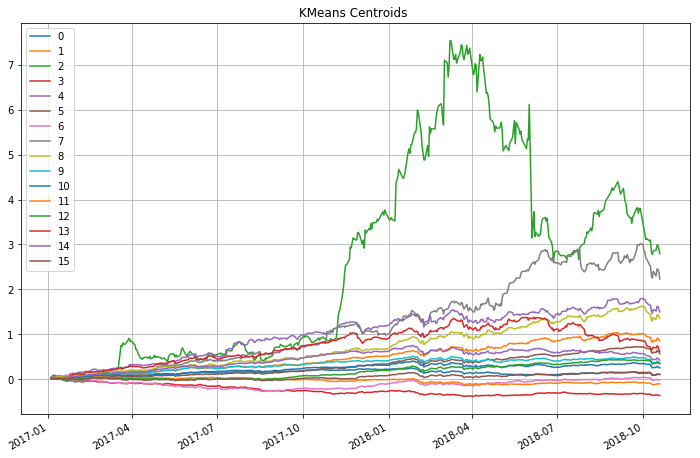

In [90]:
centroids = kmeans.cluster_centers_
centroids_df = pd.DataFrame(centroids)
centroids_df.columns = X.columns
# Convert it to timeseries data
centroids_df = centroids_df.T
centroids_df.plot(figsize=(12,8),
                  title="KMeans Centroids ",
                  grid=True
                 )
plt.show()

In [91]:
preclusters = kmeans.labels_
preclusters

array([10,  1, 14,  7,  5, 13,  8,  5,  3, 15,  5,  0, 10,  9, 15,  6,  3,
        0,  0, 11,  7, 10, 11, 11,  0, 10,  9,  9, 11,  8,  0, 11,  0, 10,
       11,  9,  0,  9, 15,  9, 10, 10,  6, 10,  1,  1, 10, 10,  3, 11,  1,
       14, 14, 15,  0,  4, 10, 15, 11,  1, 12,  6, 11, 14,  3, 15, 10,  0,
       14, 15,  5,  1, 15, 10,  0,  8, 10, 10, 11,  5, 15,  9,  1, 12, 12,
        0, 14,  3, 15, 11, 15, 10, 14, 14,  9, 11, 11,  8,  0,  6, 10,  5,
       12,  0, 15, 15,  0,  0,  9,  3, 15,  5,  5,  0, 15,  5,  0,  5,  0,
        0,  9,  0,  0, 12, 11, 15, 12,  0,  9,  9,  1, 10, 12, 11, 10,  1,
        0, 11, 14, 12,  5, 15,  9, 15, 11,  6,  0, 15,  6,  6,  3, 12,  0,
       11, 10,  0,  0, 15,  0,  5, 10,  0, 10, 12, 11,  5, 14, 12,  0, 15,
       11, 15,  0, 15,  0,  1,  0,  0, 12,  0, 12, 15, 12, 11, 15, 14, 15,
       11, 10, 10, 15, 15, 10,  5,  5,  6,  6, 14,  3, 11,  8,  9,  0, 11,
       15, 10, 12, 10,  0,  3, 11,  0, 15, 15, 14, 15, 11, 12,  6, 11,  3,
        5,  0, 10,  5, 11

### Phase II Cluster Purifying

This phase of the 3PTC mainly aims to refine (purify) the pre- clusters and improve their quality. Moreover, the number of time series in the data set (cardinality) is reduced by defining a prototype for each group of very similar time series. It considerably decreases the complexity of 3PTC.

In this phase, a distance matrix is developed between the time series in each pre-cluster. ED is chosen as distance metric.

The sub-clusters (made from a pre-cluster) are desirable, such that most of their members are members of a natural cluster (class). That is, given that the pre-clusters are generated approximately and not precisely, they are often mixed with time series from different classes. Therefore, they should be recognized and separated by searching in the pre-clusters. As a result, the pre-clusters are broken into so-called pure sub-clusters. Of course assigning each time series to a separate cluster (singleton cluster) provides the highest purity. However, the best solution is the purest and smallest number of clusters.

Considering the pre-cluster $PC_i$, a similarity measure between the members of $PC_i$ is calculated and stored in an m-by-m similarity matrix, $M_{m \times 􏰂m}$, where $M_{ij}$ is the similarity measure between time series $F_i$ and time series $F_j$. 


#### Pure Cluster Search Definition

In [92]:
from itertools import combinations
#  affinity_threshold = (similarity[similarity >= avg_similarity] - avg_similarity).sum() / unasigned_count + avg_similarity
def calc_affinity_threshold(similarity_matrix, avg_similarity, pcu):    
    accumulated_sum = 0
    above_mean_count = 0
    for x,y in combinations(pcu,2):
        similarity = similarity_matrix[x,y]
        if similarity >= avg_similarity:
            accumulated_sum +=  similarity - avg_similarity 
            above_mean_count += 1
            
    if above_mean_count > 0:
#         return (accumulated_sum / len(pcu)) + avg_similarity
        return (accumulated_sum / above_mean_count) + avg_similarity
    else:
        return avg_similarity

In [93]:
def affinity_to_cluster(similarity_matrix, cluster):        
    return similarity_matrix[:,cluster].sum(axis=1) / len(cluster)    


In [94]:
def create_prototype(precluster, subcluster):
      return {'prototype': precluster.iloc[subcluster].mean(axis=0),'companies': precluster.iloc[subcluster].index.values}
    

In [95]:
def pure_cluster_search_fix(precluster, similarity):

    # Declarations
    subcluster = [] # Holds the current subcluster that is being built
    prototypes = [] # Holds the found prototypes in an array of dicts of the format {prototype: timeseries[], companies: string[]}
    affinity_threshold = 0
    
    # Initializations
    unassigned = precluster.reset_index().index.values.tolist()
    avg_similarity = similarity.mean()
    
    # Generate square similarity matrix with diagonal of 1 (1 this is maximum similarity)
    similarity_matrix = squareform(similarity)
    np.fill_diagonal(similarity_matrix, 1)
    
    
    affinity = affinity_to_cluster(similarity_matrix, unassigned)
    
    # Initialize the highest affinity sample to form a subcluster
    max_aff_idx = (affinity == affinity[unassigned].max()).argmax()
    subcluster.append(max_aff_idx)
    unassigned.remove(max_aff_idx)
    affinity = affinity_to_cluster(similarity_matrix, subcluster)

    # Do the purifying until there are no samples left in the preclusters
    while len(subcluster) + len(unassigned) > 0:
        unasigned_count = len(unassigned)
        
        if unasigned_count == 0:
            prototypes.append(create_prototype(precluster, subcluster))
            break
        
        affinity_threshold = calc_affinity_threshold(similarity_matrix, avg_similarity, unassigned)
        
        # From affinity slice the PCu elements and then get max affinity index
        max_aff_idx = (affinity == affinity[unassigned].max()).argmax()            

        if affinity[max_aff_idx] >= affinity_threshold:
            # High Affinity: Move to the subcluster 
            subcluster.append(max_aff_idx)          
            unassigned.remove(max_aff_idx) 
            affinity = affinity_to_cluster(similarity_matrix, subcluster)
            
        
        else:
            min_aff_idx = (affinity == affinity[subcluster].min()).argmax()
            # Get the min affinity index of the subcluster sample
            if affinity[min_aff_idx] < affinity_threshold:
                
                # Low Affinity: Move back to the unassigned 
                subcluster.remove(min_aff_idx)
                unassigned.append(min_aff_idx)
                affinity = affinity_to_cluster(similarity_matrix, subcluster)
                
            else:
                
                print('creating prototype', subcluster)
                # The subcluster is clean: Create Prototype
                prototypes.append(create_prototype(precluster, subcluster))
                subcluster = []

                # Reset the affinity to use only what is left in the unasigned preclustered elements
                affinity = affinity_to_cluster(similarity_matrix, unassigned)
                
                 # Initialize the highest affinity sample to form a subcluster
                max_aff_idx = (affinity == affinity[unassigned].max()).argmax()
                subcluster.append(max_aff_idx)
                unassigned.remove(max_aff_idx)
                affinity = affinity_to_cluster(similarity_matrix, subcluster)
    
    return prototypes

#### Purifying the Pre-clusters 

In [96]:
from scipy.spatial.distance import pdist, squareform
from sklearn.preprocessing import minmax_scale

In [97]:
''' Uses the minimax scale of sklearn but inserts 0 to define the lower baundary'''
def zeromax_scale(X):
    arr = np.append(X, 0)
    arr = minmax_scale(arr)
    return arr[:-1]

In [98]:
prototypes = []
for pc in range(k_pc):
    cur_precluster = X.iloc[preclusters == pc]
    dist = pdist(cur_precluster)
    dist = zeromax_scale(dist)
#     dist = minmax_scale(dist)
    similarity = (1 - dist)
    prototypes += pure_cluster_search_fix(cur_precluster,similarity)


creating prototype [32, 26, 61, 3, 5, 17, 29, 54, 4, 21, 65, 48, 6, 11, 23, 42, 2, 18, 41, 27, 52, 16, 50, 31, 38, 57, 13, 59, 28, 67, 8, 15, 36, 49, 55, 25, 64, 39, 19, 10]
creating prototype [35, 22, 53, 43, 66, 20, 45, 44]
creating prototype [0, 46]
creating prototype [12, 51]
creating prototype [63, 47]
creating prototype [33]
creating prototype [30]
creating prototype [58, 37]
creating prototype [60, 40]
creating prototype [34]
creating prototype [9]
creating prototype [62]
creating prototype [1]
creating prototype [56]
creating prototype [14]
creating prototype [7]
creating prototype [13, 17, 21, 6, 12, 22, 16, 20, 15, 0, 2, 3, 1, 5, 14, 18, 4]
creating prototype [7]
creating prototype [11, 8]
creating prototype [9]
creating prototype [10]
creating prototype [19]
creating prototype [10, 2, 15, 5, 3, 4, 9, 13]
creating prototype [16, 8, 12]
creating prototype [18, 17]
creating prototype [1]
creating prototype [6, 14]
creating prototype [7, 0]
creating prototype [3, 2, 4]
creating 

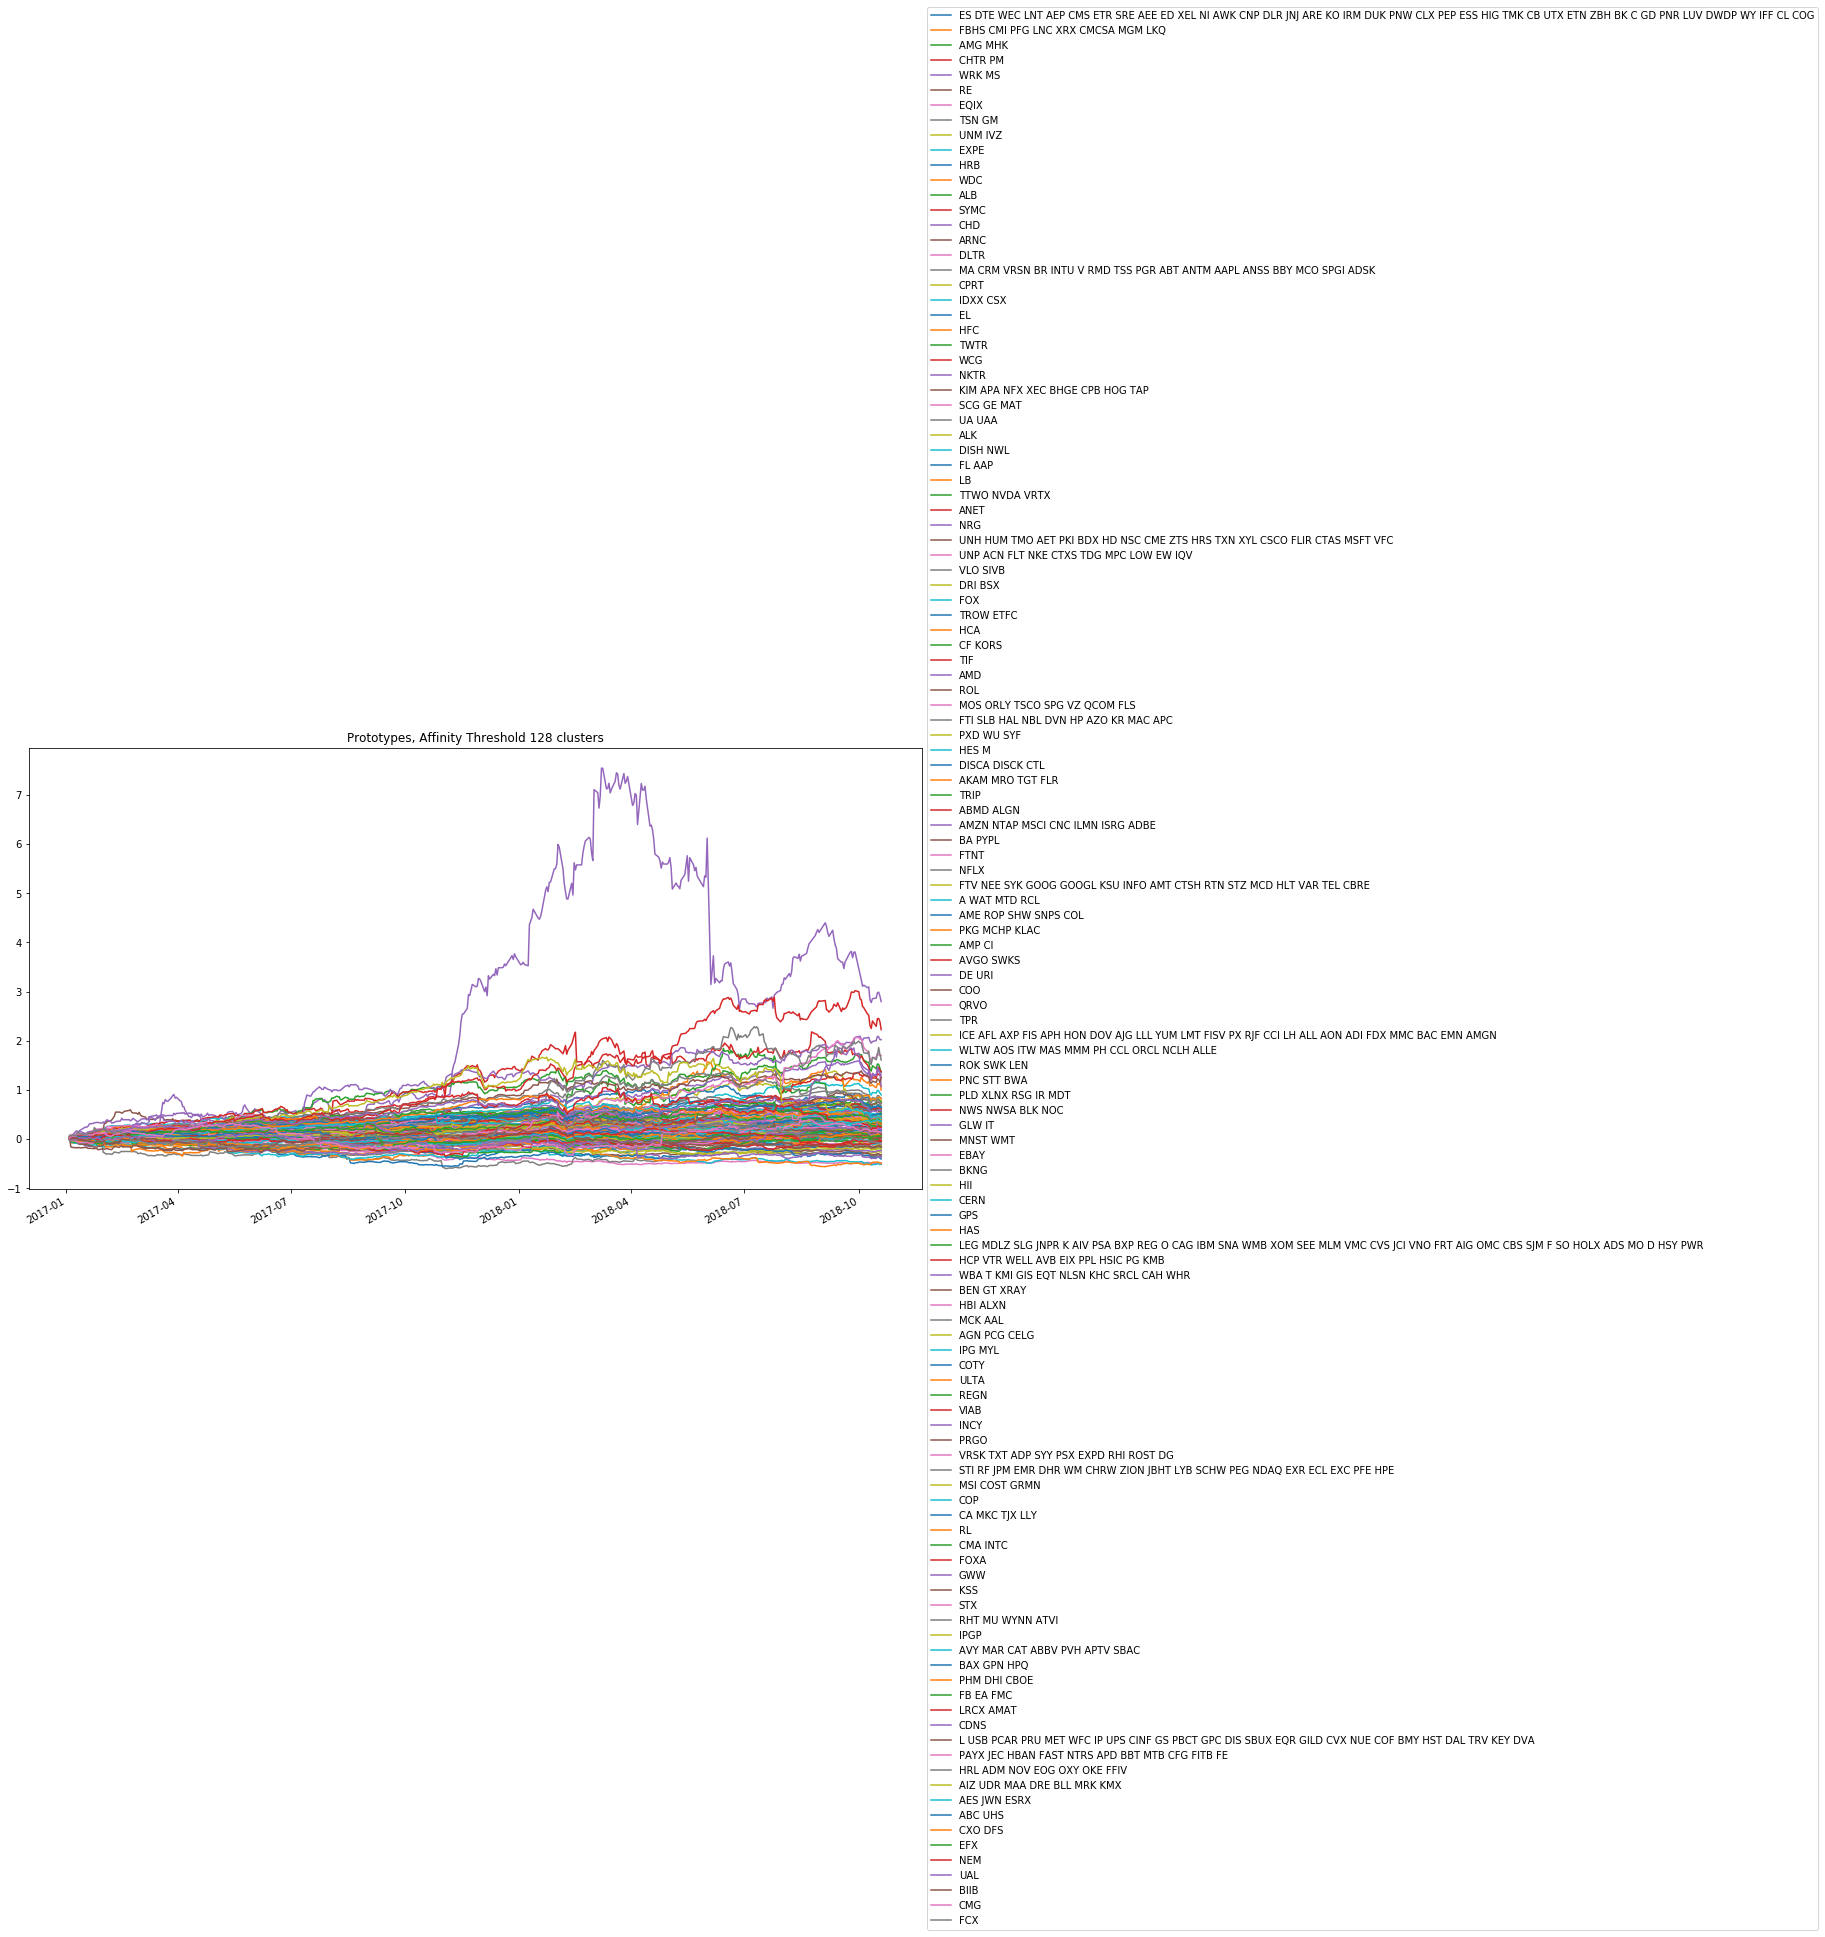

In [99]:
for proto in prototypes:
    companies = " ".join(str(x) for x in  proto['companies'])
    proto['prototype'].plot(figsize=(16,9), legend=True, label=companies)
    
plt.title('Prototypes, Affinity Threshold {} clusters'.format(len(prototypes)))
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5));

### Phase III Merging

1. **Merging**

In the second phase of the 3PTC, similar time series are grouped using ED based on their similarity in time. However, two time series that are dissimilar in time can be similar in shape. As mentioned, similarity in shape is desirable in the clustering of time series because finding clusters of time series that are similar in shape are very close to ground truth (natural clusters).

DTW is used as a distancce metric.

2. **Mapping**

The merging process results in the emergence of some clusters constructed from the prototypes of the sub-clus- ters. Thus, a mapping activity is carried out to assign the original time series to their corresponding prototypes. All time series of each sub-cluster are assigned to the cluster to which the corresponding prototype is assigned.

In [100]:
prototypes_df = pd.DataFrame()
for proto in prototypes:
    prototypes_df = prototypes_df.append(proto['prototype'], ignore_index=True)

#### Defining Distance Metrics Helpers

In [101]:
from scipy.spatial.distance import euclidean
from fastdtw import fastdtw
from sklearn.metrics import pairwise_distances

def dtw_distance(x,y):
    distance,_ = fastdtw(x,y,dist=euclidean)
    return distance

def dtw_affinity(X):
    return pairwise_distances(X, metric=dtw_distance)

#### Calculating the DTW distance using FastDTW

In [102]:
# dist_matrix = dtw_affinity(prototypes_df)
print("Loading DTW Distance from:", "prototypes_dtw_{}.npy".format(data_size))
dist_matrix = np.load("prototypes_dtw_{}.npy".format(data_size))

Loading DTW Distance from: prototypes_dtw_500x453.npy


#### Merging: Agglomerative Clustering

In [103]:
from sklearn.cluster import AgglomerativeClustering

Mapping:

In [37]:
def map_prototypes_to_companies(prototype_labels, companies):
    mapped = np.empty_like(companies)
    for prototype_idx, cluster in enumerate(prototype_labels):
        proto_companies = prototypes[prototype_idx]['companies']
        mapped[np.isin(companies, proto_companies)] = cluster
        
    return mapped

### Fine Tuning The HyperParameters
1. Calculate the distance matrix so that we can quickly experiment without doing the same calculations multiple times
1. Create a dataframe storing the scores
1. Calculate a combined score
1. Record the index scores and the combined index scores and plot them to gain insight

##### Scores

In [115]:
min_clusters = 2
max_clusters = 100 if len(prototypes_df.index) > 100 else len(prototypes_df.index) - 1

linkage = 'complete'
# linkage = 'average'

ag_score = pd.DataFrame(index=np.arange(min_clusters, max_clusters), columns=['silhuette', 'calinski', 'davis'])
ag_score.index.name = 'n_clusters'

##### Experimentation

In [116]:
for n in range(min_clusters, max_clusters):
    ag = AgglomerativeClustering(n_clusters=n,affinity='precomputed',linkage=linkage)
    ag.fit(dist_matrix)

    sil = metrics.silhouette_score(prototypes_df,ag.labels_)
    calinski = metrics.calinski_harabaz_score(prototypes_df,ag.labels_)
    davis = metrics.davies_bouldin_score(prototypes_df, ag.labels_);
        
    ag_score.loc[n] = [sil, calinski, davis]

    

In [117]:
for n in range(min_clusters, max_clusters):
    ag = AgglomerativeClustering(n_clusters=n,affinity='precomputed',linkage=linkage)
    ag.fit(dist_matrix)
    labels = map_prototypes_to_companies(ag.labels_, X.index.values)

    sil = metrics.silhouette_score(X,labels)
    calinski = metrics.calinski_harabaz_score(X,labels)
    davis = metrics.davies_bouldin_score(X,labels);
        
    ag_score.loc[n] = [sil, calinski, davis]

Saving figure scores_500x453_complete_dtw


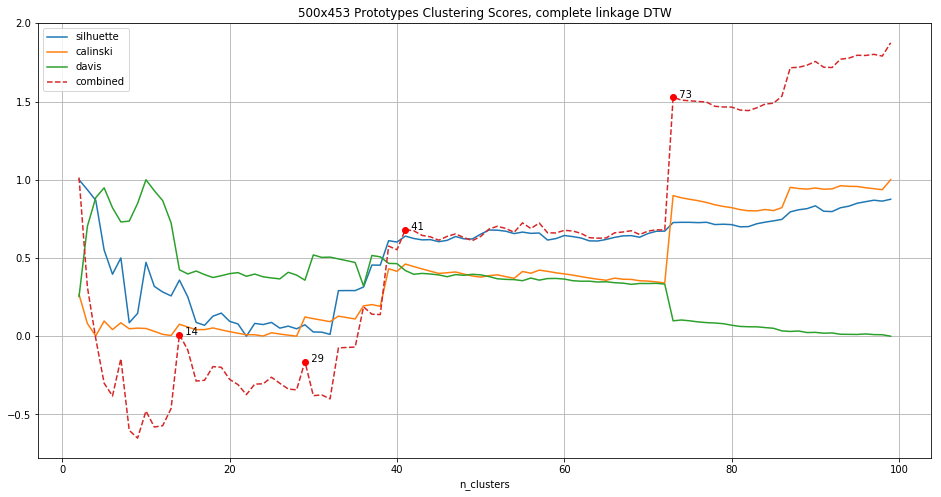

In [120]:
scale_scores(ag_score).plot()
comb_score = calc_combined_index(ag_score)
comb_score.plot(figsize=(16,8), x_compat=True, grid=True, label='combined', legend=True, ls='--')


# n = min_clusters
# while n < max_clusters:
#     n_with_max_score= comb_score.loc[n:n+5].idxmax()
    
#     plt.plot(n_with_max_score, comb_score.loc[n_with_max_score], 'ro')
#     plt.annotate('  {}'.format(n_with_max_score),
#                  xy=(n_with_max_score, comb_score.loc[n_with_max_score]))
    
#     n = n+5

handpicked = [14,29,41,73]
for n in handpicked:
    plt.plot(n, comb_score.loc[n], 'ro')
    plt.annotate('  {}'.format(n),
                 xy=(n, comb_score.loc[n]))
    
plt.title('{} Prototypes Clustering Scores, {} linkage DTW'.format(data_size,linkage));
save_fig('scores_{}_{}_dtw'.format(data_size,linkage), prefix='3PTCSClusters/Prototypes/{}-linkage'.format(linkage))

In [121]:
print('Prototypes Scores {} {} linkage'.format(data_size, linkage))
print()
print(ag_score.loc[handpicked])
ag_score.loc[handpicked].to_csv( IMAGES_PATH+'/3PTCSClusters/Prototypes/{}-linkage/'.format(linkage) + 'scores_df_{}_{}.csv'.format(data_size,linkage))

Prototypes Scores 500x453 complete linkage

             silhuette calinski    davis
n_clusters                              
14          -0.0822077  16.3023  3.75628
29           -0.149054  19.2004  3.39464
41          -0.0163393  40.3874  3.73007
73          0.00395559  67.7729  1.98177


In [122]:
X.shape

(497, 453)

In [ ]:
for n in handpicked:
    ag = AgglomerativeClustering(n_clusters=n, linkage=linkage)
    ag.fit(dist_matrix)
    labels = map_prototypes_to_companies(ag.labels_, X.index.values)
    
    folder = os.path.join('3PTCSClusters','{}-linkage'.format(linkage))
    save_clustering_results(X,
                            n,
                            labels,
                            folder,
                            'Three Phase Clustering {} Linkage, {}'.format(linkage.title(),data_size),
                            data_size=data_size
                           )
    
    clustered_df = pd.DataFrame(index=X.index, data=labels, columns=['Cluster'])
    clustered_df.index.set_names('company')
    validation_set = snp500_validation[snp500_validation.columns.intersection(clustered_df.index)]
    allocation, stats =  create_portfolio(snp500,validation_set , clustered_df)
    
    folder = os.path.join('3PTCSClusters','{}-linkage'.format(linkage), '{}_{}_clusters'.format(data_size,n))
    save_fig(fig_id='portfolio_{}_clusters_{}'.format(n,data_size), prefix=folder, tight_layout=False, resolution=300)
    
    stats['Num of Portfolio Companies'] = [(allocation['Allocation'] > 0).sum(), len(validation_set.columns)]
    stats['Algorithm'] = [
        'Three Phase Clustering {} Linkage'.format(linkage.title()),
        'Equal Allocation of S&P500'
    ]
    stats['Distance Metric'] = ['DTW', np.nan]
    stats['Data Size'] = data_size
    stats['Number of clusters'] = [n, np.nan]
    
    allocation.to_csv(os.path.join(IMAGES_PATH,folder, 'portfolio-allocation.csv'))
    stats.to_csv(os.path.join(IMAGES_PATH,folder, 'portfolio-stats.csv'))